<a href="https://colab.research.google.com/github/Yogeshwaran0529/AI-Driven-Customer-Segmentation-in-Marketing-Analytics-/blob/main/Customer_Segmentation_Analysis_Using_AI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Customer Segmentation in Marketing Analytics **

# **IMPORTING**

In [4]:
# cell 0: imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Optional
%matplotlib inline
sns.set(style="whitegrid")

In [5]:
from google.colab import drive
drive.mount('/content/drive')

df = pd.read_csv('/content/drive/MyDrive/online_retail_II.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **ANALYZING/CHECKING THE DATA**

In [6]:
#1: load data

print(df.shape)
df.head()


(1067371, 8)


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1067371 entries, 0 to 1067370
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   Invoice      1067371 non-null  object 
 1   StockCode    1067371 non-null  object 
 2   Description  1062989 non-null  object 
 3   Quantity     1067371 non-null  int64  
 4   InvoiceDate  1067371 non-null  object 
 5   Price        1067371 non-null  float64
 6   Customer ID  824364 non-null   float64
 7   Country      1067371 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 65.1+ MB


In [8]:
df1 = df.copy()

# **CLEANING THE DATASET**

In [9]:
#2: quick peek & cleanup basics
# Columns usually: Invoice, StockCode, Description, Quantity, InvoiceDate, UnitPrice, Customer ID, Country
df1.columns = df1.columns.str.replace(" ", "_")

# Convert Invoicedate column to datetime column
df1['InvoiceDate'] = pd.to_datetime(df1['InvoiceDate'], errors='coerce')

# drop rows with missing Customer ID (we need customer-level features)
df1 = df1.dropna(subset=['Customer_ID'])
df1['Customer_ID'] = df1['Customer_ID'].astype(int).astype(str)  # keep as string id

df1

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer_ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085,United Kingdom
...,...,...,...,...,...,...,...,...
1067366,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680,France
1067367,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680,France
1067368,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680,France
1067369,581587,22138,BAKING SET 9 PIECE RETROSPOT,3,2011-12-09 12:50:00,4.95,12680,France


In [10]:
# remove credit notes (optional): invoices that start with 'C' may be order that was cancellations
df1 = df1[~df1['Invoice'].astype(str).str.startswith('C')]

df1.shape

(805620, 8)

In [11]:
# Remove negative or zero quantity & non-positive price
df1 = df1[(df1['Quantity'] > 0) & (df1['Price'] > 0)]

df1 = df1.reset_index(drop=True)
df1.shape


(805549, 8)

In [12]:
# cell 3: create transaction-level metric: Amount
df1['Amount'] = df1['Quantity'] * df1['Price']
df1.head()


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer_ID,Country,Amount
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085,United Kingdom,83.4
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom,81.0
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom,81.0
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085,United Kingdom,100.8
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085,United Kingdom,30.0


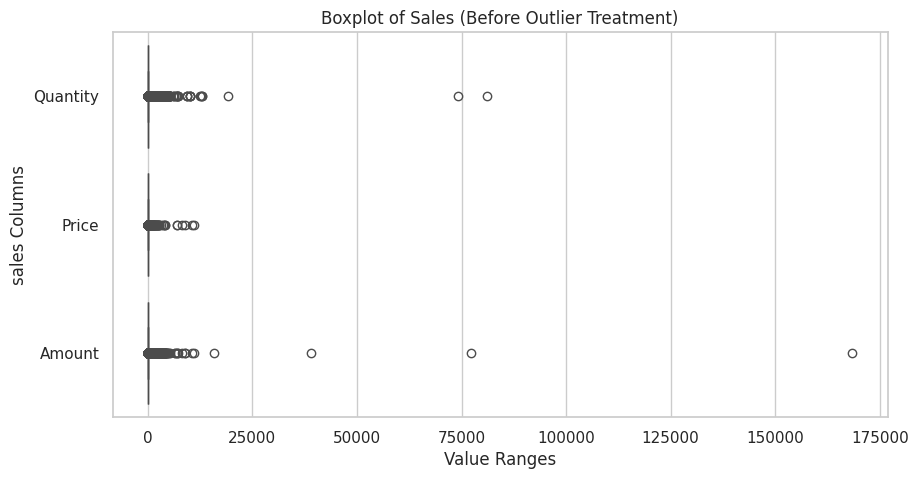

In [13]:
plot_cols = ["Quantity","Price","Amount"]

plt.figure(figsize=(10, 5))

sns.boxplot(data=df1[plot_cols], orient='h')

plt.title("Boxplot of Sales (Before Outlier Treatment)")
plt.xlabel("Value Ranges")
plt.ylabel("sales Columns")
plt.show()

In [14]:
df1[df1["Amount"]> 350].sort_values("Amount", ascending=False)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer_ID,Country,Amount
805075,581483,23843,"PAPER CRAFT , LITTLE BIRDIE",80995,2011-12-09 09:15:00,2.08,16446,United Kingdom,168469.6
444784,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346,United Kingdom,77183.6
563060,556444,22502,PICNIC BASKET WICKER 60 PIECES,60,2011-06-10 15:28:00,649.50,15098,United Kingdom,38970.0
338262,530715,84347,ROTATING SILVER ANGELS T-LIGHT HLDR,9360,2010-11-04 11:36:00,1.69,15838,United Kingdom,15818.4
98315,502263,M,Manual,1,2010-03-23 15:22:00,10953.50,12918,United Kingdom,10953.5
...,...,...,...,...,...,...,...,...,...
224246,517893,22423,REGENCY CAKESTAND 3 TIER,32,2010-08-03 09:00:00,10.95,15061,United Kingdom,350.4
94876,501836,22423,REGENCY CAKESTAND 3 TIER,32,2010-03-19 17:03:00,10.95,15808,United Kingdom,350.4
567340,556917,22423,REGENCY CAKESTAND 3 TIER,32,2011-06-15 13:37:00,10.95,12415,Australia,350.4
120112,504851,22423,REGENCY CAKESTAND 3 TIER,32,2010-04-18 10:31:00,10.95,15482,United Kingdom,350.4


In [15]:
# optional: trim extremely large outliers if needed (depends on dataset)
df_1 = df1[df1['Amount'] < df1['Amount'].quantile(0.995)]

df_1.shape

(801432, 9)

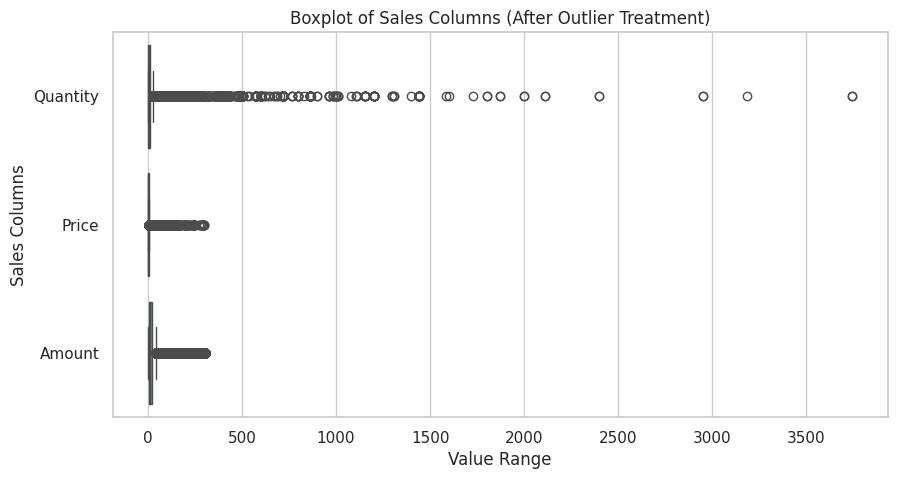

In [16]:
plt.figure(figsize=(10,5))

sns.boxplot(data=df_1[plot_cols], orient='h')

plt.title("Boxplot of Sales Columns (After Outlier Treatment)")
plt.xlabel("Value Range")
plt.ylabel("Sales Columns")
plt.show()

In [17]:
# cell 4: customer-level aggregation (features)
# We'll compute several features per customer:
# - recency (days since last purchase)
# - frequency (number of unique invoices/orders)
# - total_amount (sum of Amount)
# - avg_order_value
# - total_items (sum of Quantity)
# - unique_products
# - avg_unit_price

snapshot_date = df_1['InvoiceDate'].max() + pd.Timedelta(days=1)  # reference date for recency

customer = df_1.groupby('Customer_ID').agg({
    'InvoiceDate': [lambda x: (snapshot_date - x.max()).days,  # recency
                    'nunique'],  # number of unique invoices (frequency proxy)
    'Amount': ['sum', 'mean'],
    'Quantity': 'sum',
    'StockCode': 'nunique',
    'Price': 'mean'
})

customer

InvoiceDate           Amount            Quantity StockCode  \
             <lambda_0> nunique      sum       mean      sum   nunique   
Customer_ID                                                              
12346               529      11   372.86  11.298788       70        26   
12347                 2       8  5633.32  22.266087     3286       126   
12348                75       5  2019.40  39.596078     2714        25   
12349                19       4  4428.69  25.306800     1624       138   
12350               310       1   334.40  19.670588      197        17   
...                 ...     ...      ...        ...      ...       ...   
18283                 4      22  2736.65   2.775507     1733       352   
18284               432       1   461.68  16.488571      494        28   
18285               661       1   427.00  35.583333      145        12   
18286               477       2  1296.43  19.349701      608        67   
18287                43       7  4182.99  26.987032     3013       120   

                Price  
                 mean  
Customer_ID            
12346        6.253333  
12347        2.546087  
12348        3.786275  
12349        8.459657  
12350        3.841176  
...               ...  
18283        1.744168  
18284        3.253214  
18285        8.350000  
18286        4.273134  
18287        2.234452  

[5842 rows x 7 columns]

In [18]:
# flatten multiindex
customer.columns = ['_'.join(col).strip() for col in customer.columns.values]

customer

,InvoiceDate_<lambda_0>,InvoiceDate_nunique,Amount_sum,Amount_mean,Quantity_sum,StockCode_nunique,Price_mean
Customer_ID,,,,,,,
12346,529,11,372.86,11.298788,70,26,6.253333
12347,2,8,5633.32,22.266087,3286,126,2.546087
12348,75,5,2019.40,39.596078,2714,25,3.786275
12349,19,4,4428.69,25.306800,1624,138,8.459657
12350,310,1,334.40,19.670588,197,17,3.841176
...,...,...,...,...,...,...,...
18283,4,22,2736.65,2.775507,1733,352,1.744168
18284,432,1,461.68,16.488571,494,28,3.253214
18285,661,1,427.00,35.583333,145,12,8.350000


In [19]:
#rename column
customer = customer.reset_index().rename(columns={
    'InvoiceDate_<lambda_0>': 'recency_days',
    'InvoiceDate_nunique': 'num_orders',
    'Amount_sum': 'total_amount',
    'Amount_mean': 'avg_amount_per_line',
    'Quantity_sum': 'total_items',
    'StockCode_nunique': 'unique_products',
    'UnitPrice_mean': 'avg_unit_price'
})

# add avg_order_value = total_amount / num_orders
customer['avg_order_value'] = customer['total_amount'] / customer['num_orders']
# fill infinite or NaN (defensive)
customer = customer.replace([np.inf, -np.inf], np.nan).fillna(0)

print(customer.shape)
customer

(5842, 9)


,Customer_ID,recency_days,num_orders,total_amount,avg_amount_per_line,total_items,unique_products,Price_mean,avg_order_value
0,12346,529,11,372.86,11.298788,70,26,6.253333,33.896364
1,12347,2,8,5633.32,22.266087,3286,126,2.546087,704.165000
2,12348,75,5,2019.40,39.596078,2714,25,3.786275,403.880000
3,12349,19,4,4428.69,25.306800,1624,138,8.459657,1107.172500
4,12350,310,1,334.40,19.670588,197,17,3.841176,334.400000
...,...,...,...,...,...,...,...,...,...
5837,18283,4,22,2736.65,2.775507,1733,352,1.744168,124.393182
5838,18284,432,1,461.68,16.488571,494,28,3.253214,461.680000
5839,18285,661,1,427.00,35.583333,145,12,8.350000,427.000000
5840,18286,477,2,1296.43,19.349701,608,67,4.273134,648.215000


# **EDA**

In [20]:
# 5: quick EDA of the customer features
customer[['recency_days','num_orders','total_amount','avg_order_value','total_items','unique_products']].describe().round(2)


,recency_days,num_orders,total_amount,avg_order_value,total_items,unique_products
count,5842.00,5842.00,5842.00,5842.00,5842.00,5842.00
mean,201.69,6.19,2499.91,345.39,1532.04,82.35
std,209.60,12.51,8837.19,334.69,6319.36,116.51
min,1.00,1.00,2.90,2.90,1.00,1.00
25%,26.00,1.00,340.58,178.30,187.00,19.00
50%,96.00,3.00,861.40,279.90,484.00,45.00
75%,380.00,7.00,2216.22,409.96,1347.50,104.00
max,739.00,385.00,376243.72,8951.26,287391.00,2550.00


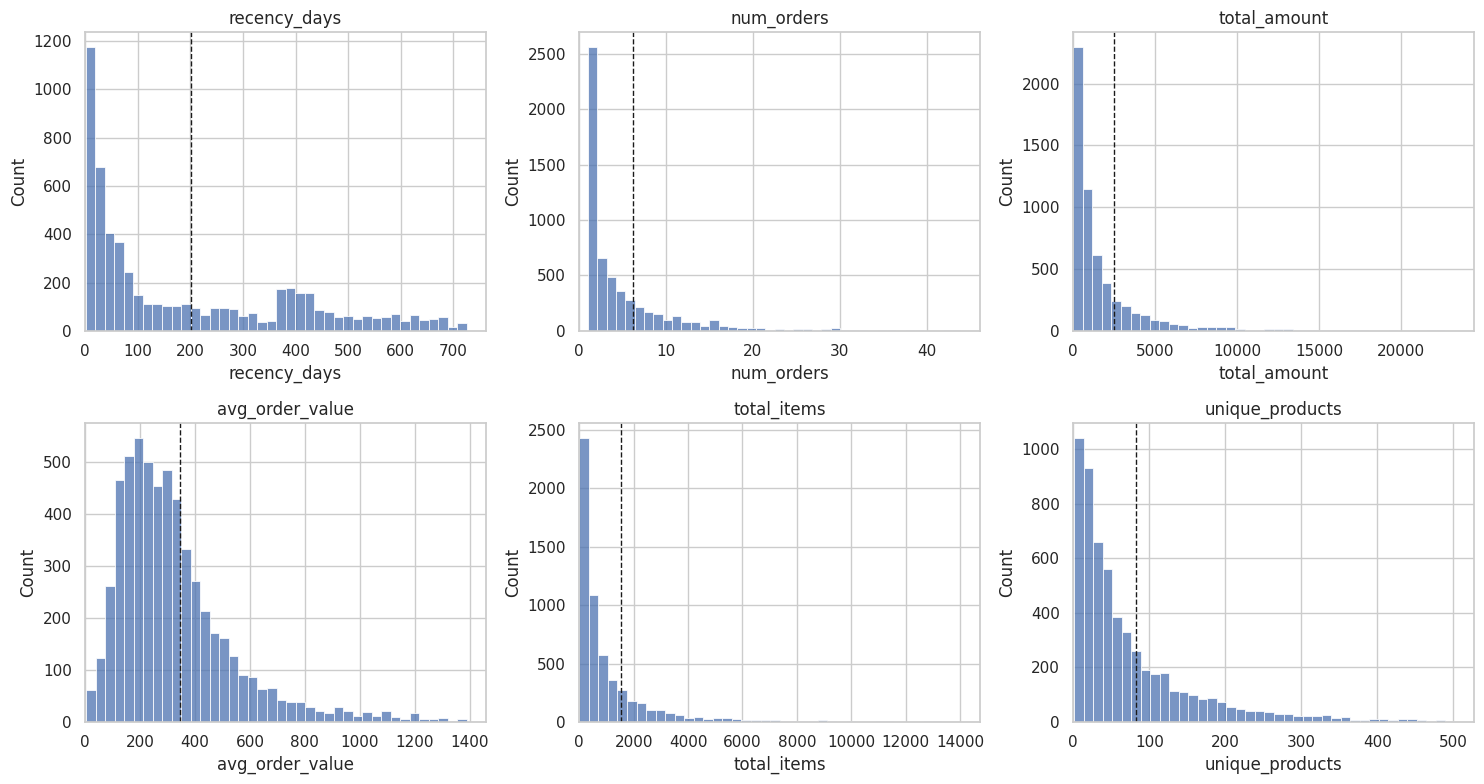

In [21]:
#6 : EDA
cols = ['recency_days', 'num_orders', 'total_amount', 'avg_order_value',
        'total_items', 'unique_products']

# Option A: Percentile clipping (focus on bulk of data)
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()
for ax, col in zip(axes, cols):
    s = customer[col].dropna()
    # choose percentile to clip to — 0.99 is usually good; lower (0.95) if still skewed
    clip_val = s.quantile(0.99)
    k = s.mean()
    sns.histplot(s[s <= clip_val], bins=40, ax=ax, kde=False)
    ax.set_title(col)
    ax.set_xlim(left=0)          # start at 0 for clarity
    # optional: show a vertical line where the 99th percentile lies
    ax.axvline(k, color='k', linestyle='--', linewidth=1.0)
plt.tight_layout()
plt.show()





In [22]:
# cell 7: prepare features for clustering
features = ['recency_days','num_orders','total_amount','total_items','avg_order_value','unique_products']
df_X = customer[features].copy()

# log transform heavily skewed features (total_amount, total_items, unique_products)
for col in ['num_orders','total_amount','total_items','unique_products','avg_order_value']:
   df_X[col] = np.log1p(df_X[col])

df_X


,recency_days,num_orders,total_amount,total_items,avg_order_value,unique_products
0,529,2.484907,5.923881,4.262680,3.552383,3.295837
1,2,2.197225,8.636632,8.097731,6.558432,4.844187
2,75,1.791759,7.611051,7.906547,6.003591,3.258097
3,19,1.609438,8.396085,7.393263,7.010468,4.934474
4,310,0.693147,5.815324,5.288267,5.815324,2.890372
...,...,...,...,...,...,...
5837,4,3.135494,7.914855,7.458186,4.831454,5.866468
5838,432,0.693147,6.137036,6.204558,6.137036,3.367296
5839,661,0.693147,6.059123,4.983607,6.059123,2.564949
5840,477,1.098612,7.168141,6.411818,6.475764,4.219508


In [23]:
# scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_X)
X_scaled

array([[ 1.5617132 ,  1.1683234 , -0.64150473, -1.29763785, -2.9227101 ,
        -0.3952409 ],
       [-0.95280172,  0.81085796,  1.35503863,  1.28639072,  1.36444605,
         0.8879586 ],
       [-0.6044913 ,  0.30703873,  0.60022651,  1.15757281,  0.57314482,
        -0.4265183 ],
       ...,
       [ 2.19153477, -1.05806518, -0.54196881, -0.81188279,  0.65234392,
        -1.00096593],
       [ 1.31360167, -0.55424595,  0.27425133,  0.15043557,  1.24654708,
         0.37025384],
       [-0.75717532,  0.66450416,  1.13600133,  1.22796806,  1.13071238,
         0.84784983]])

In [24]:
# cell 8: PCA for visualization (2 components)
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)
print("Explained variance ratio (2 components):", pca.explained_variance_ratio_.sum().round(3))

# add to customer df for plotting
customer['pca1'] = X_pca[:,0]
customer['pca2'] = X_pca[:,1]

Explained variance ratio (2 components): 0.84


In [25]:
customer

,Customer_ID,recency_days,num_orders,total_amount,avg_amount_per_line,total_items,unique_products,Price_mean,avg_order_value,pca1,pca2
0,12346,529,11,372.86,11.298788,70,26,6.253333,33.896364,-1.991669,-1.856863
1,12347,2,8,5633.32,22.266087,3286,126,2.546087,704.165000,2.692627,0.402514
2,12348,75,5,2019.40,39.596078,2714,25,3.786275,403.880000,1.141176,0.099210
3,12349,19,4,4428.69,25.306800,1624,138,8.459657,1107.172500,2.291091,1.137080
4,12350,310,1,334.40,19.670588,197,17,3.841176,334.400000,-1.444825,0.774399
...,...,...,...,...,...,...,...,...,...,...,...
5837,18283,4,22,2736.65,2.775507,1733,352,1.744168,124.393182,2.299638,-1.879167
5838,18284,432,1,461.68,16.488571,494,28,3.253214,461.680000,-0.898494,1.517403
5839,18285,661,1,427.00,35.583333,145,12,8.350000,427.000000,-1.957765,1.961448
5840,18286,477,2,1296.43,19.349701,608,67,4.273134,648.215000,0.134734,1.898791


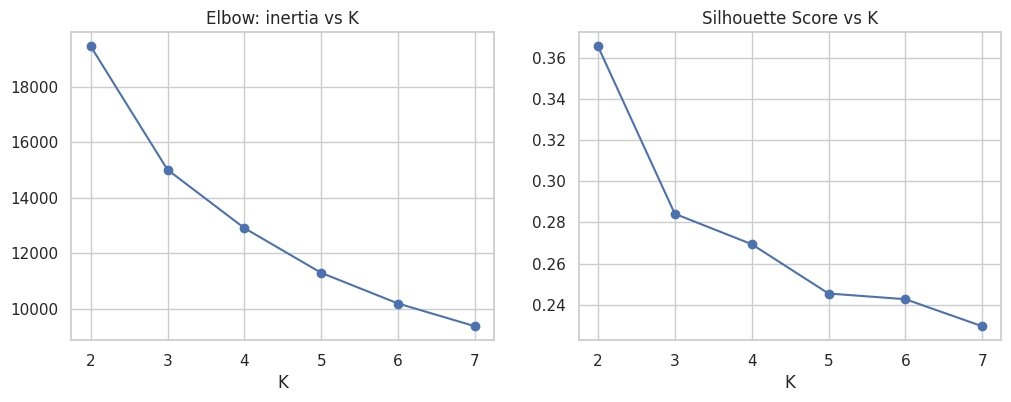

In [26]:
#9: find best K (elbow + silhouette) - quick and small K range
inertia = []
silhouette = []
K_range = range(2,8)
for k in K_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labs = km.fit_predict(X_scaled)
    inertia.append(km.inertia_)
    silhouette.append(silhouette_score(X_scaled, labs))

# plot
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(K_range, inertia, '-o')
plt.title('Elbow: inertia vs K')
plt.xlabel('K')
plt.subplot(1,2,2)
plt.plot(K_range, silhouette, '-o')
plt.title('Silhouette Score vs K')
plt.xlabel('K')
plt.show()


In [27]:
#  10: choose K ( best by silhouette / elbow)
# Suppose silhouette suggests K=4
K = 4
km = KMeans(n_clusters=K, random_state=42, n_init=20)
customer['cluster'] = km.fit_predict(X_scaled)

# cluster centers (in original scaled space) and cluster sizes
customer['cluster'].value_counts().sort_index()


,count
cluster,
0,1473
1,1092
2,2053
3,1224


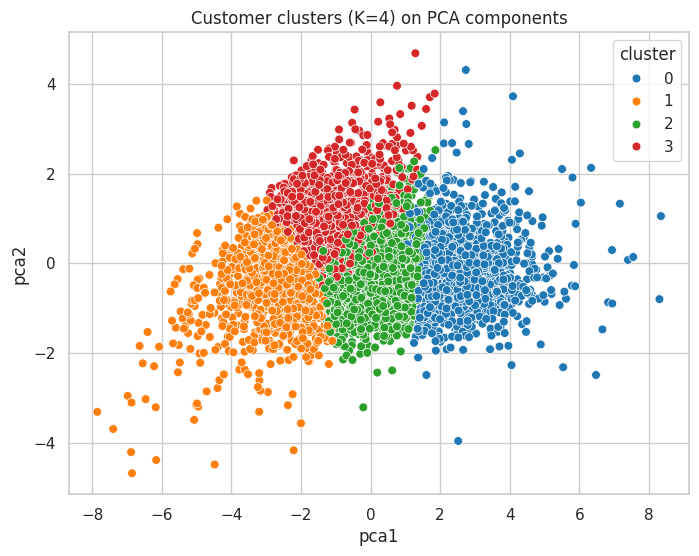

In [28]:
# cell 11: visualize clusters on PCA plane
plt.figure(figsize=(8,6))
sns.scatterplot(data=customer, x='pca1', y='pca2', hue='cluster', palette='tab10', s=40)
plt.title(f"Customer clusters (K={K}) on PCA components")
plt.legend(title='cluster')
plt.show()


In [29]:
#12: cluster profiling - compute mean of original features per cluster
profile = customer.groupby('cluster')[['recency_days','num_orders','total_amount','avg_order_value','total_items','unique_products']].agg(['count','mean','median']).round(2)
profile


recency_days                num_orders               total_amount  \
               count    mean median      count   mean median        count   
cluster                                                                     
0               1473   58.32   24.0       1473  16.45   11.0         1473   
1               1092  324.32  319.5       1092   1.52    1.0         1092   
2               2053   84.86   53.0       2053   3.84    3.0         2053   
3               1224  460.79  430.0       1224   1.93    1.0         1224   

                          avg_order_value                 total_items  \
            mean   median           count    mean  median       count   
cluster                                                                 
0        7740.33  4372.15            1473  500.42  391.13        1473   
1         178.12   156.86            1092  127.05  123.62        1092   
2        1054.91   954.09            2053  321.75  275.90        2053   
3         688.53   495.16            1224  393.25  312.30        1224   

                         unique_products                 
            mean  median           count    mean median  
cluster                                                  
0        4747.32  2521.0            1473  202.91  162.0  
1         100.46    77.5            1092   11.35    9.0  
2         642.31   524.0            2053   59.70   49.0  
3         432.18   274.5            1224   38.62   29.0

In [30]:
# 13: creating readable cluster summary table
summary = customer.groupby('cluster').agg({
    'recency_days':'mean',
    'num_orders':'mean',
    'total_amount':'mean',
    'avg_order_value':'mean',
    'total_items':'mean',
    'unique_products':'mean'
}).rename(columns={
    'recency_days':'recency_days_mean',
    'num_orders':'num_orders_mean',
    'total_amount':'total_amount_mean',
    'avg_order_value':'avg_order_value_mean',
    'total_items':'total_items_mean',
    'unique_products':'unique_products_mean'
}).round(2)

summary['size'] = customer['cluster'].value_counts().sort_index().values
summary = summary.reset_index()
summary


,cluster,recency_days_mean,num_orders_mean,total_amount_mean,avg_order_value_mean,total_items_mean,unique_products_mean,size
0,0,58.32,16.45,7740.33,500.42,4747.32,202.91,1473
1,1,324.32,1.52,178.12,127.05,100.46,11.35,1092
2,2,84.86,3.84,1054.91,321.75,642.31,59.70,2053
3,3,460.79,1.93,688.53,393.25,432.18,38.62,1224


In [31]:
customer

,Customer_ID,recency_days,num_orders,total_amount,avg_amount_per_line,total_items,unique_products,Price_mean,avg_order_value,pca1,pca2,cluster
0,12346,529,11,372.86,11.298788,70,26,6.253333,33.896364,-1.991669,-1.856863,1
1,12347,2,8,5633.32,22.266087,3286,126,2.546087,704.165000,2.692627,0.402514,0
2,12348,75,5,2019.40,39.596078,2714,25,3.786275,403.880000,1.141176,0.099210,2
3,12349,19,4,4428.69,25.306800,1624,138,8.459657,1107.172500,2.291091,1.137080,0
4,12350,310,1,334.40,19.670588,197,17,3.841176,334.400000,-1.444825,0.774399,3
...,...,...,...,...,...,...,...,...,...,...,...,...
5837,18283,4,22,2736.65,2.775507,1733,352,1.744168,124.393182,2.299638,-1.879167,0
5838,18284,432,1,461.68,16.488571,494,28,3.253214,461.680000,-0.898494,1.517403,3
5839,18285,661,1,427.00,35.583333,145,12,8.350000,427.000000,-1.957765,1.961448,3
5840,18286,477,2,1296.43,19.349701,608,67,4.273134,648.215000,0.134734,1.898791,3


In [32]:
#14: save results
customer[['Customer_ID','cluster','pca1','pca2'] + features].to_csv('/content/drive/MyDrive//customer_clusters.csv', index=False)
summary.to_csv('/content/drive/MyDrive/cluster_summary.csv', index=False)


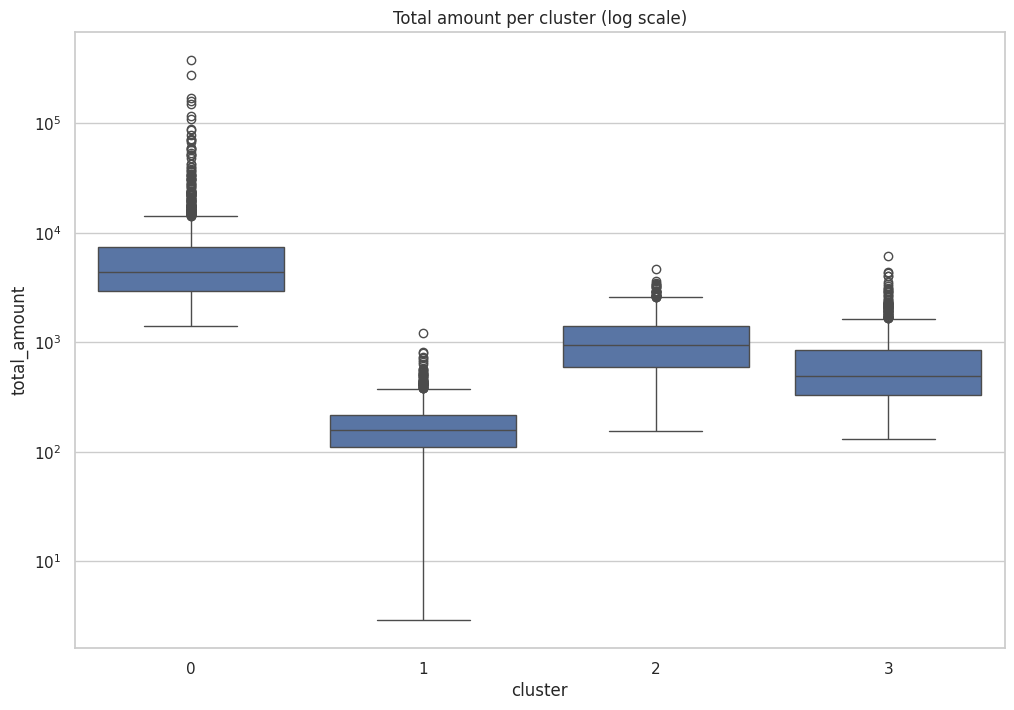

In [33]:
# cell 15: simple plots for each cluster -- boxplots for one feature (example: total_amount)
plt.figure(figsize=(12,8))
sns.boxplot(x='cluster', y='total_amount', data=customer)
plt.yscale('log')
plt.title("Total amount per cluster (log scale)")
plt.show()


In [34]:
# Create a textual summary table to feed GPT
print(summary.to_markdown(index=False))


|   cluster |   recency_days_mean |   num_orders_mean |   total_amount_mean |   avg_order_value_mean |   total_items_mean |   unique_products_mean |   size |
|----------:|--------------------:|------------------:|--------------------:|-----------------------:|-------------------:|-----------------------:|-------:|
|         0 |               58.32 |             16.45 |             7740.33 |                 500.42 |            4747.32 |                 202.91 |   1473 |
|         1 |              324.32 |              1.52 |              178.12 |                 127.05 |             100.46 |                  11.35 |   1092 |
|         2 |               84.86 |              3.84 |             1054.91 |                 321.75 |             642.31 |                  59.7  |   2053 |
|         3 |              460.79 |              1.93 |              688.53 |                 393.25 |             432.18 |                  38.62 |   1224 |


In [35]:
# 17: train a small decision tree to extract rules (interpretable)
from sklearn.tree import DecisionTreeClassifier, export_text


clf = DecisionTreeClassifier(max_depth=3, random_state=42)
clf.fit(X_scaled, customer['cluster'])
rules = export_text(clf, feature_names=features)
print(rules)


|--- total_amount <= 0.67
|   |--- recency_days <= 0.27
|   |   |--- total_amount <= -0.85
|   |   |   |--- class: 1
|   |   |--- total_amount >  -0.85
|   |   |   |--- class: 2
|   |--- recency_days >  0.27
|   |   |--- avg_order_value <= -0.59
|   |   |   |--- class: 1
|   |   |--- avg_order_value >  -0.59
|   |   |   |--- class: 3
|--- total_amount >  0.67
|   |--- unique_products <= 0.20
|   |   |--- total_amount <= 1.03
|   |   |   |--- class: 2
|   |   |--- total_amount >  1.03
|   |   |   |--- class: 0
|   |--- unique_products >  0.20
|   |   |--- num_orders <= 0.19
|   |   |   |--- class: 0
|   |   |--- num_orders >  0.19
|   |   |   |--- class: 0

